In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import least_squares
#from pandas import Series, DataFrame
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
%matplotlib qt5
#
# if pade.py is not in the current directory, set this path:
#
import sys
sys.path.append('../Python_libs')
import rac_pade_functions as racx

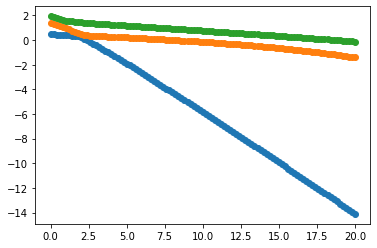

,l,E1,E2,E3,E4
0,0.0,0.469219,1.365173,1.938043,3.271038
1,0.2,0.457846,1.314401,1.844238,3.242423
2,0.4,0.446073,1.251127,1.760926,3.215267
3,0.6,0.433754,1.173608,1.690292,3.189317
4,0.8,0.420648,1.082215,1.632448,3.164365


In [2]:
Angs2Bohr=1.8897259886
au2eV=27.211386027
au2cm=219474.63068
#
#  files in the current directory do not need the path name
#
#df = pd.read_csv("/home/thomas/Python/StabPlots/Stab_data/1D_a0.2_b0_c0.14/crossing_1.dat", delim_whitespace=True)
df = pd.read_csv("sb_rac.csv")
#df = pd.read_csv("crossing_1.dat", delim_whitespace=True)
plt.cla()
plt.plot(df.l.values, df.E1.values, 'o-')
plt.plot(df.l.values, df.E2.values, 'o-')
plt.plot(df.l.values, df.E3.values, 'o-')
plt.show()
df[:5]

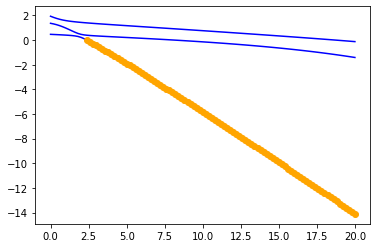

In [3]:
i_neg = np.argmin(abs(df.E1.values))
if df.E1[i_neg] > 0:
    i_neg += 1
ls = df.l.values[i_neg:]
Es = df.E1.values[i_neg:]
plt.cla()
plt.plot(df.l.values, df.E1.values, 'b-')
plt.plot(df.l.values, df.E2.values, 'b-')
plt.plot(df.l.values, df.E3.values, 'b-')
plt.plot(ls, Es, 'o-', color="orange")
plt.show()

In [4]:
k2s = -Es
ks  = np.sqrt(k2s)

In [18]:
#
#  this will go into a module at some point
#
def chi2_gen(params, ks, k2s, lbs, pade):
    """
    fit l = pade(k; params) to the data in ks, lbs using the weights sigma 
    """
    diffs = pade(ks, k2s, params) - lbs
    return np.sum(np.square(diffs)) / len(ks)

def pade_21(k, ksq, params):
    """ Pade [2.1] """
    l = params[0]
    a = params[1]
    b = params[2]
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    return l*(ksq + aak2 + a4b2) / (a4b2 + aak2)

def pade_31(k, ksq, params):
    """ 
    Pade [3,1]  
    """
    l = params[0]
    a = params[1]
    b = params[2]
    d = params[3]
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    ddk=d*d*k
    num = (ksq + aak2 + a4b2) * (1 + ddk)
    den = a4b2 + aak2 + ddk*a4b2
    return l * num / den

In [21]:
#
#  this will need a lot of fiddling around
#  d(chi)/da = 1/N * Sum 2*diffs * d(pade)/da
#  at the moment d(pade)/da is jac[i,1], I think, so that would be good
#
def chi2_gen_j(params, ks, k2s, lbs, pade):
    """
    fit l = pade(k; params) to the data in ks, lbs using the weights sigma 
    """
    diffs = pade(ks, k2s, params) - lbs
    return np.sum(np.square(diffs)) / len(ks)

def pade_31j(k, ksq, params):
    """
    f = l*fr1*fr2/den
    df/dl = fr1*fr2/den
    df/da = -4*a*k**2*l0 * fr1 * fr2 / den**2
    df/db = -2*b*k**2*l0 * fr1 * fr2 / den**2
    df/dd = 4*a**2*d*k**2*l0 * fr1 / den**2 
    
    where
    fr1 = (k**2 + 2*a**2*k + a**4 + b**2)
    fr2 = (1 + d**2*k)
    den = (a**4 + b**2 + 2*a**2*k + k*d**2 * (a**4 + b**2))
    """
    l = params[0]
    a = params[1]
    b = params[2]
    d = params[3]
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    ddk=d*d*k
    fr1 = (ksq + aak2 + a4b2)
    fr2 = (1 + ddk)
    den = a4b2 + aak2 + ddk*a4b2
    dl = fr1*fr2/den
    f = l*dl
    da = -4*a*ksq*l * dl/den
    db = -2*b*ksq*l * dl/den
    dd = 4*a**2*d*ksq*l * fr1/den**2
    return f, (dl, da, db, dd)

In [22]:
#
#  start with a plain BFGS
#
E0, G0 = 1.75, 0.4
p0s=[1] + racx.guess(E0, G0) + [0.5]
print("Start parameters:",p0s)
res = minimize(chi2_gen, p0s, args=(ks, k2s, ls, pade_31), 
               method='BFGS', options={'gtol':1e-7})
out = tuple([res.fun] + list(res.x[1:]) + [res.nit, res.nfev, res.njev])
print("chi=%e,  a=%f,  b=%f,  d=%f,  Iter=%d, nE=%d, nG=%d" % out)

#res = minimize(chi2_gen, p0s, args=(ks, k2s, ls, pade_31j), 
#               method='BFGS', jac=True, options={'gtol':1e-7})
out = tuple([res.fun] + list(res.x[1:]) + [res.nit, res.nfev, res.njev])
print("chi=%e,  a=%f,  b=%f,  d=%f,  Iter=%d, nE=%d, nG=%d" % out)



print("Er=%f,  Gamma=%f" % racx.res_ene(res.x[1], res.x[2]))

Start parameters: [1, 0.27471836030808555, 1.32502669697271, 0.5]
chi=3.015623e-06,  a=0.271347,  b=1.281328,  d=0.454252,  Iter=85, nE=1020, nG=168
chi=3.015623e-06,  a=0.271347,  b=1.281328,  d=0.454252,  Iter=85, nE=1020, nG=168
Er=1.636380,  Gamma=0.377372


In [21]:
cons = ({'type': 'ineq', 'fun': lambda x: x[0] },
        {'type': 'ineq', 'fun': lambda x: x[1] },
        {'type': 'ineq', 'fun': lambda x: x[2] })

cons = ({'type': 'ineq', 'fun': lambda x: x[0] },
        {'type': 'ineq', 'fun': lambda x: x[1] },
        {'type': 'ineq', 'fun': lambda x: x[2] },
        {'type': 'ineq', 'fun': lambda x: x[3] })


E0, G0 = 1.75, 0.4
p0s=[2.4] + racx.guess(E0, G0) + [0.5]
print(p0s)
res = minimize(chi2_gen, p0s, args=(ks, k2s, ls, pade_31), 
               method='SLSQP', constraints=cons, options={'ftol':1e-7})
print(res.fun)
print(res.x)
racx.res_ene(res.x[1], res.x[2])

[2.4, 0.27471836030808555, 1.32502669697271, 0.5]
4.232653619677929e-06
[2.39732522 0.28650934 1.27729181 0.49211911]


(1.6247359948356752, 0.41939928524556336)

In [24]:
cons = ({'type': 'ineq', 'fun': lambda x: x[0] },
        {'type': 'ineq', 'fun': lambda x: x[1] },
        {'type': 'ineq', 'fun': lambda x: x[2] })

cons = ({'type': 'ineq', 'fun': lambda x: x[0] },
        {'type': 'ineq', 'fun': lambda x: x[1] },
        {'type': 'ineq', 'fun': lambda x: x[2] },
        {'type': 'ineq', 'fun': lambda x: x[3] })


E0, G0 = 1.75, 0.4
p0s=[2.4] + racx.guess(E0, G0) + [0.5]
print(p0s)
res = minimize(chi2_gen, p0s, args=(ks, k2s, ls, pade_31), 
               method='COBYLA', constraints=cons, options={'tol':1e-6})
print(res.fun)
print(res.x)
racx.res_ene(res.x[1], res.x[2])

[2.4, 0.27471836030808555, 1.32502669697271, 0.5]
0.00026408257734821227
[2.45478076 0.27001581 1.31296403 0.50481541]


(1.7185588964678278, 0.3829051631618301)

In [ ]:
lw = np.zeros(4)
up = np.full((4), np.inf)

args=(ks, k2s, ls, pade_31)
local_min={'method'='BFGS'}

ret = dual_annealing(func, args=args, bounds=list(zip(lw, up)), seed=1234)

inf

In [ ]:
#
#  Try to make least_squares work
#
def chi_21(ps, ks, ls):
    """ Pade [2.1]
    l = params[0]
    a = params[1]
    b = params[2]
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    return l*(k*k + aak2 + a4b2) / (a4b2 + aak2)
    """
    return ps[0]*(np.square(ks) + 2*ps[1]**2*ks + ps[1]**4 + ps[2]**2) / (2*ps[1]**2*ks + ps[1]**4 + ps[2]**2) - ls

bnds=(0, np.inf)
p0s=[2.4407012,  0.16927274,  1.321711]
p0s=[1] + racx.guess(E0, G0)
res_lsq = least_squares(chi_21, p0s, args=(ks, ls), bounds=bnds)

In [ ]:
print(p0s)
print(res_lsq.x)
racx.res_ene(res_lsq.x[1], res_lsq.x[2])

In [ ]:
res_lsq.optimality

In [ ]:
res_lsq.cost